# Explore annotations from MSD-0558

In [3]:
from opensoundscape.audio import Audio
from opensoundscape.spectrogram import Spectrogram

import numpy as np
import pandas as pd
from glob import glob
from pathlib import Path

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for big visuals
%config InlineBackend.figure_format = 'retina'



In [4]:
from opensoundscape.annotations import BoxedAnnotations

# plotting settings

In [5]:
from matplotlib import pyplot as plt

# create style sheet?
# plt.style.use('./styles/sam.mplstyle')

small_txt = 7
med_txt = 8
big_txt = 8
# set text sizes
plt.rcParams['font.size'] = small_txt
plt.rcParams['axes.labelsize'] = med_txt
plt.rcParams['axes.titlesize'] = big_txt
plt.rcParams['xtick.labelsize'] = small_txt
plt.rcParams['ytick.labelsize'] = small_txt
plt.rcParams['legend.fontsize'] = med_txt
plt.rcParams['figure.titlesize'] = big_txt
# opaque legend (<1 is not fully opaque)
plt.rcParams["legend.framealpha"] = 1.0
# set figure size
plt.rcParams['figure.figsize']=[6,2.5]
plt.rcParams['figure.dpi'] = 300
# set default font
# plt.rcParams['font.sans-serif'] = "Gill Sans"
# plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = "gillsans"


# TIP use these 2 lines to list all available fonts:
# from matplotlib import font_manager
# font_manager.findSystemFonts(fontpaths=None, fontext="ttf")

# to add a font
# on linux, add .ttf font files to /usr/share/fonts/truetype/
# then follow these instructions https://scentellegher.github.io/visualization/2018/05/02/custom-fonts-matplotlib.html 

# tell matplotlib to create vector fonts 
# so you can edit them later! eg in Illustrator
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# plt.rcParams['lines.markersize'] = 1


#color and line style cycles #
# TIP: use https://coolers.co to create nice color palettes
#or modify this one https://coolors.co/35aad8-f3b61f-ba3b54-45b69c-8a96d7
from cycler import cycler
default_cycler = (cycler(color=['#35aad8','#f3b61f','#8a96d7','#45b69c','#ba3b54']) +
                  cycler(linestyle=['-', '--', '-.', ':','-']))
plt.rc('lines', linewidth=0.5)
plt.rc('axes', prop_cycle=default_cycler)

#use appropriate resolution for retina screens
%config InlineBackend.figure_format='retina'

In [6]:
file_df = pd.DataFrame(index=glob('/media/emu/datasets/labeled/ramu_10s_msd0558/clips/*.wav'))
file_df['name']=[Path(f).stem for f in file_df.index]
raven_folder = '/media/emu/datasets/labeled/ramu_10s_msd0558/raven_selection_tables/'
file_df['raven']=[f"{raven_folder}/{f}.Table.1.selections.txt" for f in file_df.name]
file_df.index.name='audio'
file_df = file_df.reset_index().set_index('name')

# Load one 

In [7]:
f=file_df.raven.values[0]
ba = BoxedAnnotations.from_raven_file(f,annotation_column='Annotation')
clip_df = ba.one_hot_clip_labels(classes=['A','B','C','V','X'],
                       full_duration=10,
                       clip_duration=2,
                       clip_overlap=1.5,
                       min_label_overlap=0.2,
                       min_label_fraction=0.5
                    ).astype(int)
clip_df.head()

/home/sml161/miniconda3/envs/opso071/lib/python3.9/site-packages/opensoundscape/annotations.py:508: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "overlap"] = [


,,A,B,C,V,X
start_time,end_time,,,,,
0.0,2.0,1,0,0,0,0
0.5,2.5,1,0,0,0,0
1.0,3.0,1,0,0,0,0
1.5,3.5,1,0,0,0,0
2.0,4.0,0,0,0,0,0


# Clean up annotations
? and U should become X

trim any spaces on labels

c->C and

remove accidental point-annotations with no annotation label

In [8]:
valid_labels = ['A','B','C','D','V','X']

In [9]:
for f in file_df.raven:
    try:
        ba = BoxedAnnotations.from_raven_file(f,annotation_column='Annotation')
        #correct typos
        ba=ba.convert_labels({'U':'X','?':'X','c':'C','A ':'A'})
        #remove annotations with no label (accidental point-annotations)
        ba.df = ba.df.dropna(subset=['annotation'])
        
        assert len(set(ba.df['annotation'])-set(valid_labels))==0
        
        ba.to_raven_file(f.replace('raven_selection_tables','cleaned_selection_tables'))
    except:
        print(f)
        raise

# Look at temporal patterns

In [10]:
for i in file_df.index:
    raven_file = file_df.at[i,'raven'].replace('raven_','cleaned_')
    ba = BoxedAnnotations.from_raven_file(raven_file,annotation_column='annotation')
    
    if len(ba.df)>0:
        clip_df = ba.one_hot_clip_labels(classes=valid_labels,
                               full_duration=10,
                               clip_duration=2,
                               clip_overlap=0,
                               min_label_overlap=0.2,
                               min_label_fraction=0.5
                            ).astype(int)
    
        for label in valid_labels:
            file_df.at[i, label]=clip_df[label].sum()
    else:
        for label in valid_labels:
            file_df.at[i, label]=0

/home/sml161/miniconda3/envs/opso071/lib/python3.9/site-packages/opensoundscape/annotations.py:508: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "overlap"] = [
/home/sml161/miniconda3/envs/opso071/lib/python3.9/site-packages/opensoundscape/annotations.py:508: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "overlap"] = [
/home/sml161/miniconda3/envs/opso071/lib/python3.9/site-packages/opensoundscape/annotations.py:508: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of al

### summary stats

Number of annotated 10-second clips:

In [11]:
len(file_df)

672

Number of clips with 1+ annotation

In [12]:
(file_df[file_df.columns[2:7]].max(1)>0).sum()

434

Number of annotations: 1284

In [13]:
file_df[file_df.columns[2:7]].sum().sum()

1284.0

### temporal patterns

In [74]:
from opensoundscape.audiomoth import audiomoth_start_time
import pytz
tz = pytz.timezone('US/Pacific')

# file_df['date']=[f.split('_')[4] for f in file_df.audio]
# file_df['time']=[f.split('_')[5] for f in file_df.audio]
strp_name = lambda f: '_'.join(Path(f).name.split('_')[2:4])+'.wav'
file_df['date']=[audiomoth_start_time(strp_name(f)).astimezone(tz).date() for f in file_df.audio]
file_df['time']=[audiomoth_start_time(strp_name(f)).astimezone(tz).time() for f in file_df.audio]
file_df['dt']=[audiomoth_start_time(strp_name(f)).astimezone(tz) for f in file_df.audio]


In [15]:
from datetime import datetime
import matplotlib

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
too much 'glyf' table data: expected 42820, received 42914 bytes
too much 'hmtx' table data


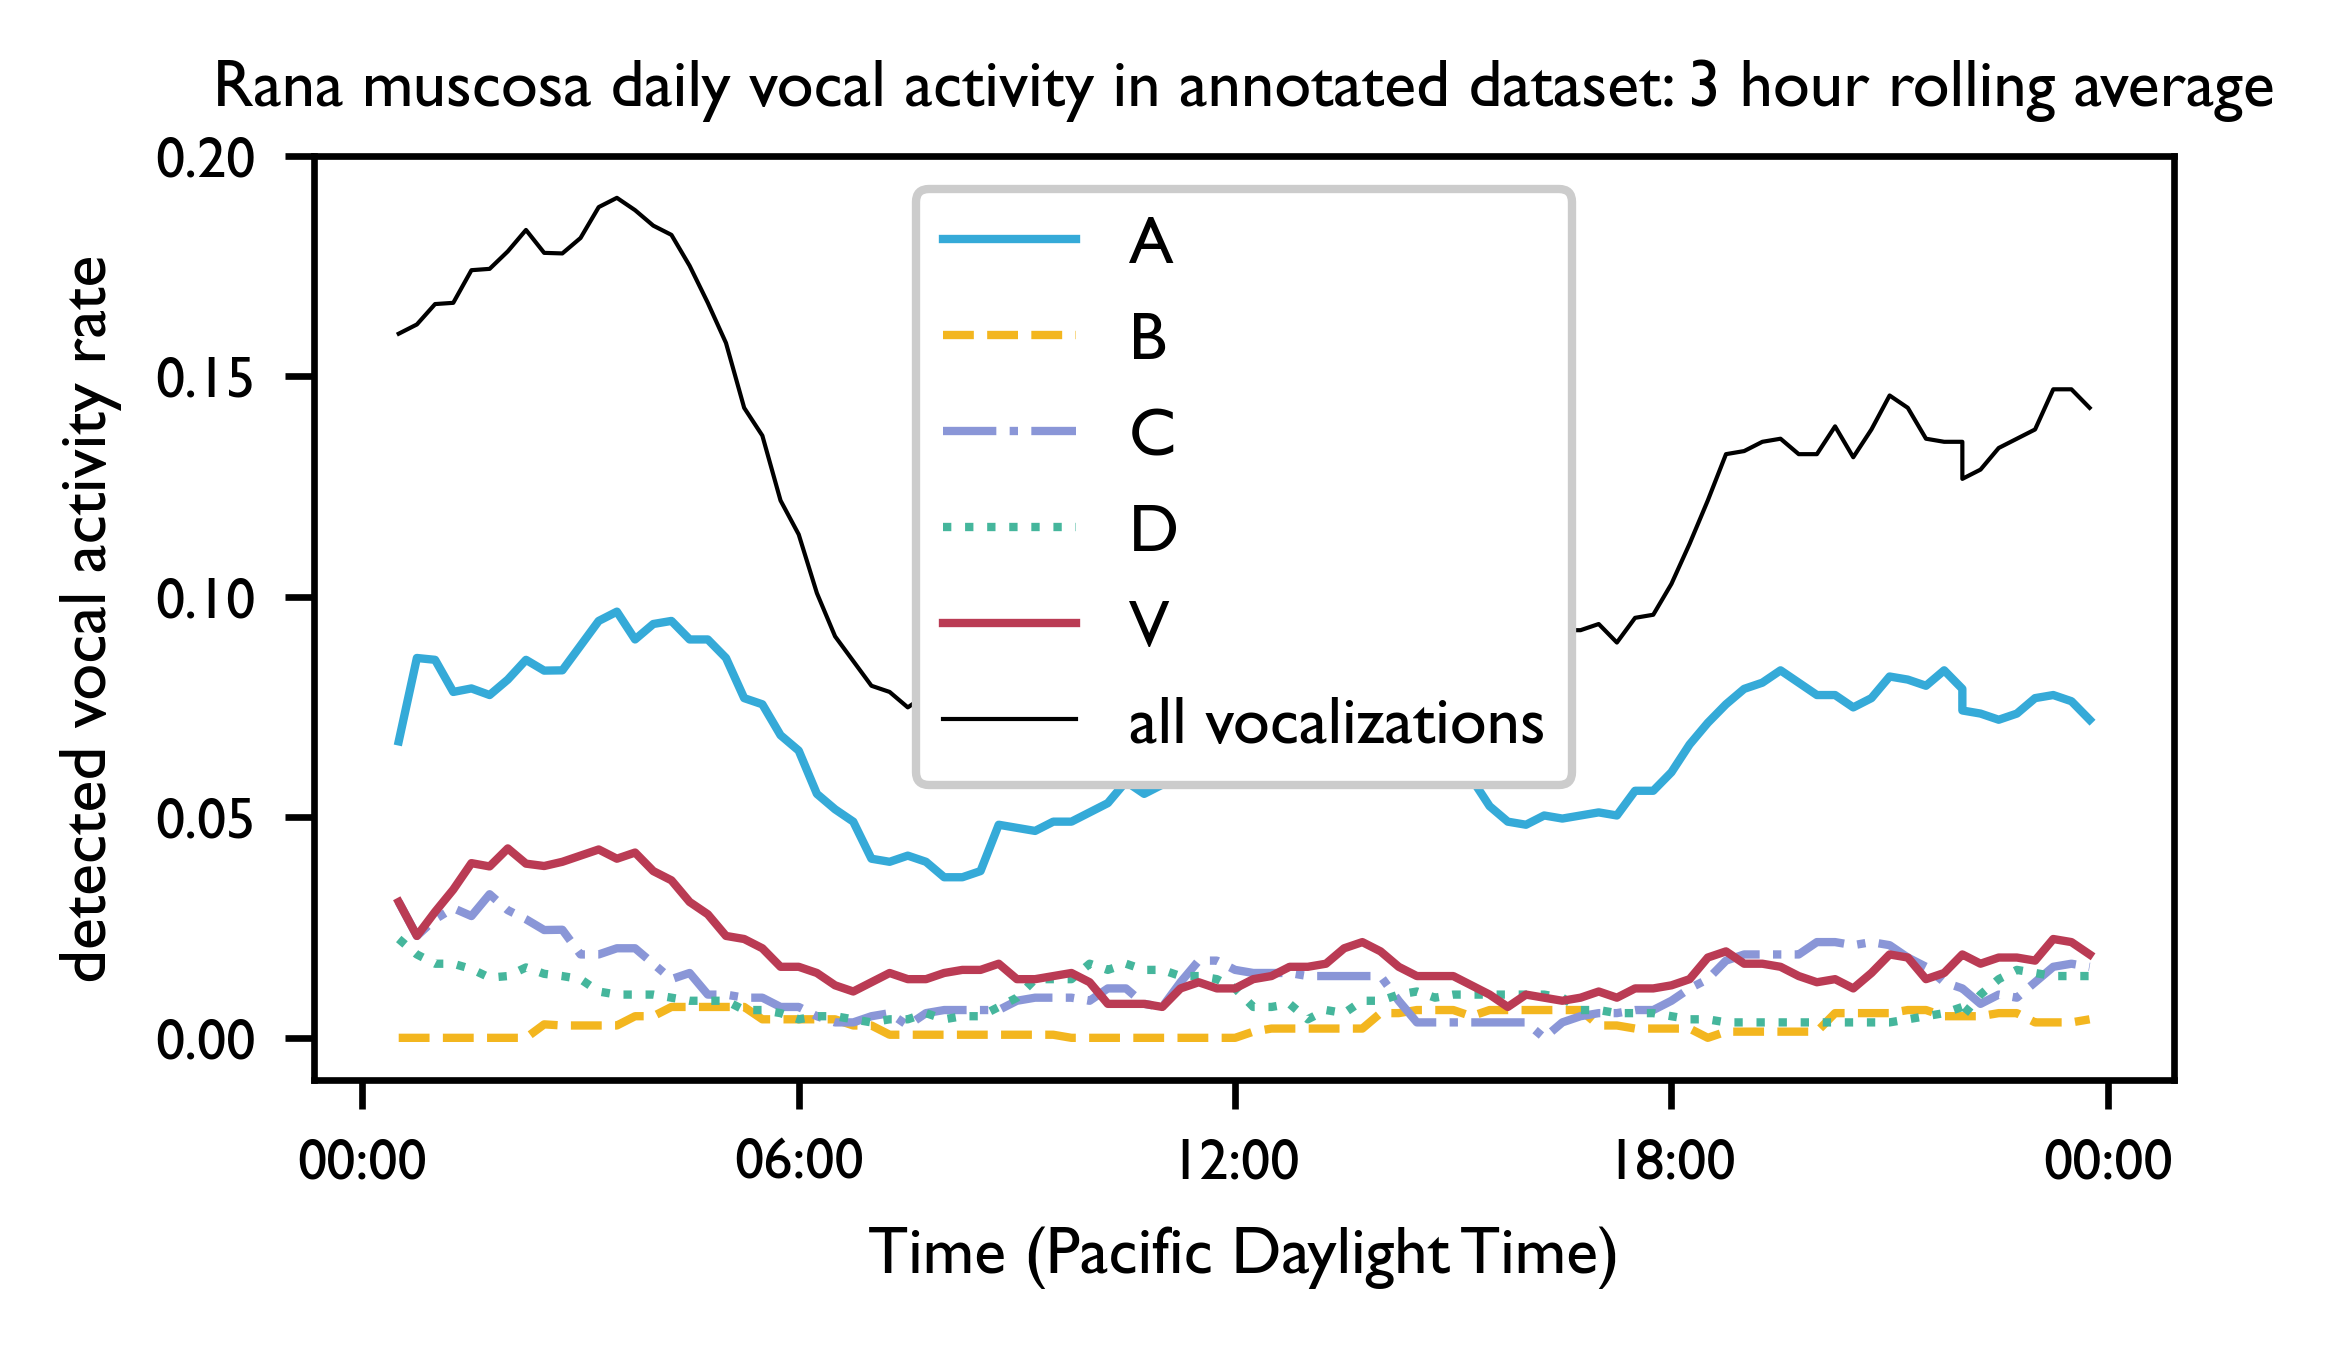

In [68]:
plt.figure(figsize=(4,2)) 

#annotations: number of annotations per 10-second clip (1 10-second clip per 15-minute time period for each of 7 days)
# divide by 17 because there are 17 clips per 10 seconds
activity = file_df.groupby('time').sum()/7 / 17

x_axis = [datetime.combine(datetime.today(),t) for t in activity.index]
for call_type in activity.columns[:-1]: #leave out the "X" label, which is for unknowns
    # plt.scatter(x_axis,activity[call_type],label=call_type,alpha=0.3,linewidths=0,s=4)
    plt.plot(x_axis,activity[call_type].rolling(12,min_periods=3).mean(),label=call_type,linewidth=1)


# plt.scatter(x_axis,activity.sum(axis=1),alpha=0.2,c='black',linewidths=0,s=4)
plt.plot(x_axis,activity.sum(axis=1).rolling(12,min_periods=3).mean(),label='all vocalizations',c='black')

# PLOTTING SETTINGS
ax = plt.gca()
#reformat x ticks to time
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))
# use less axis labels
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.legend()
ax.set_xlabel('Time (Pacific Daylight Time)')
ax.set_ylabel('detected vocal activity rate')
# ax.set_ylim(0,0.025)

# plt.xticks(rotation=90)
plt.legend()
plt.title("Rana muscosa daily vocal activity in annotated dataset: 3 hour rolling average")

plt.savefig('./figures/daily_patterns_by_call_type_annotated.pdf')
plt.show()

# is the daily pattern consistent across the 7 annotated days?

Plot activity (annotations per 10 second clip) with individual days plotted separately, and an averaged line

In [69]:
import warnings

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
too much 'glyf' table data: expected 42820, received 42914 bytes
too much 'hmtx' table data


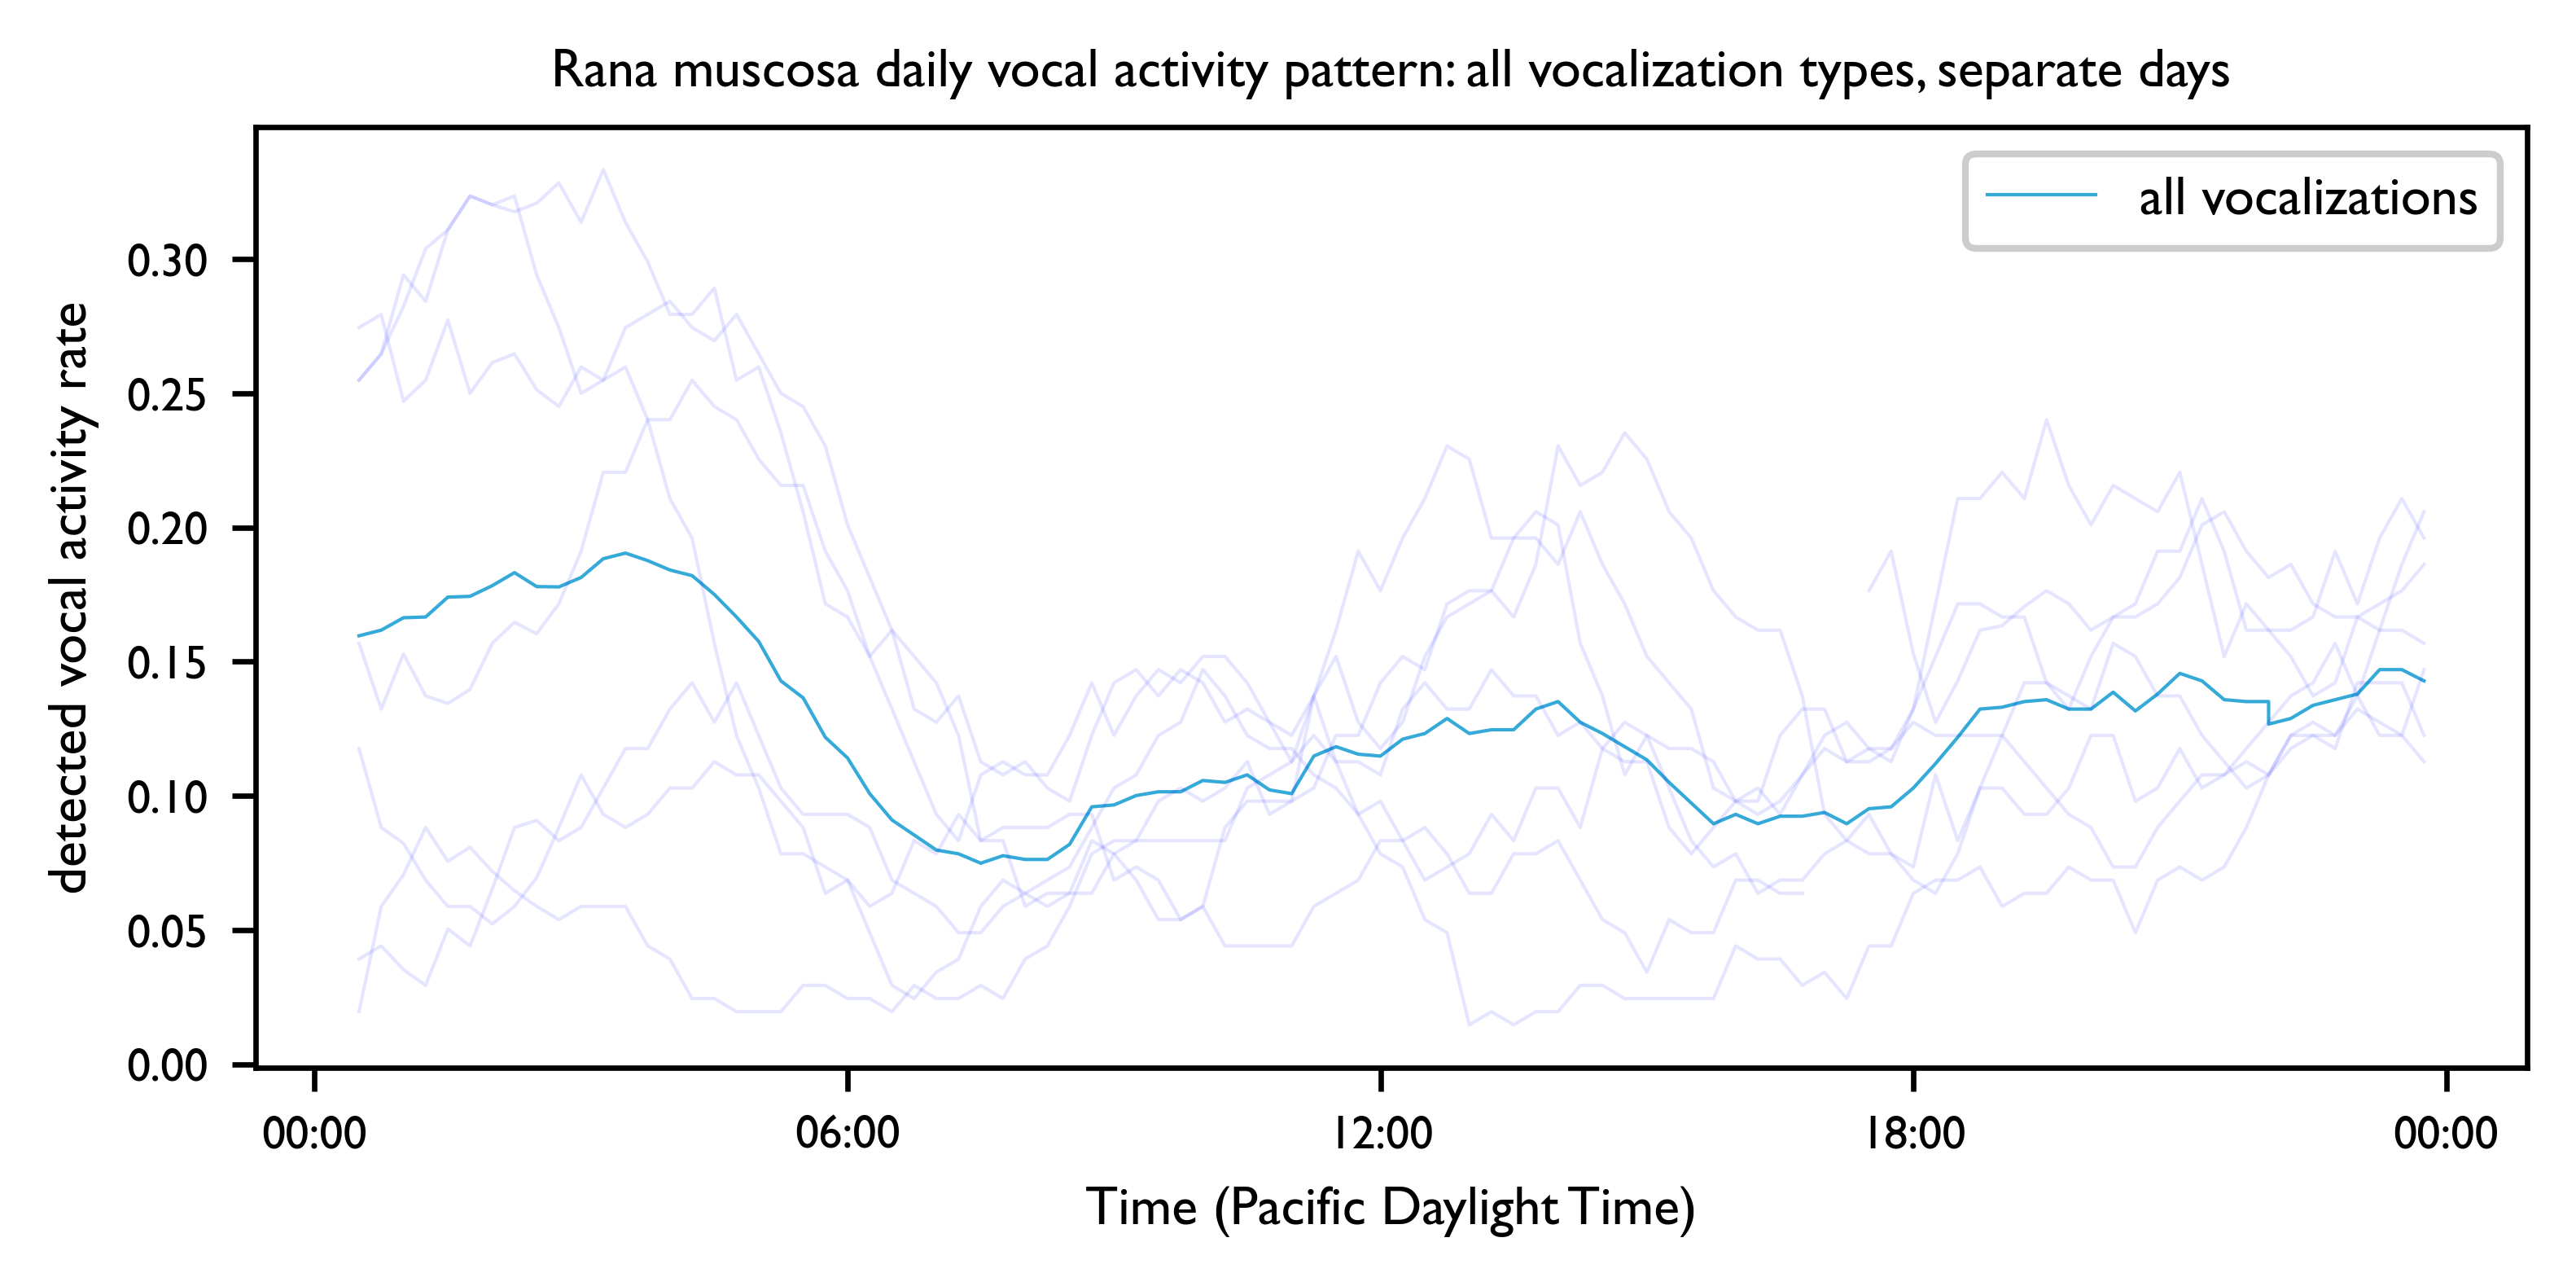

In [73]:
activity = file_df.groupby('time').sum()/7/17

warnings.simplefilter('ignore')

x_axis = [datetime.combine(datetime.today(),t) for t in activity.index]

# plt.scatter(activity.index,activity.sum(axis=1),label='all vocalizations')
plt.plot(x_axis,activity.sum(axis=1).rolling(12,min_periods=3).mean(),label='all vocalizations')
# plt.scatter(activity.index,activity.A+activity.V,label='primary')
# plt.plot(activity.index,(activity.A+activity.V).rolling(12,min_periods=3).mean(),label='primary')

for day in file_df.date.unique():
        dfi = file_df[file_df.date==day].sort_values(by='time')
        x_axis = [datetime.combine(datetime.today(),t) for t in dfi.time]
        y=dfi.sum(axis=1).rolling(12,min_periods=3).mean()/17
        plt.plot(x_axis,y,alpha=0.1,c='blue',linestyle='-')

# PLOTTING SETTINGS
ax = plt.gca()
#reformat x ticks to time
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))
# use less axis labels
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.legend()
ax.set_xlabel('Time (Pacific Daylight Time)')
ax.set_ylabel('detected vocal activity rate')

plt.title("Rana muscosa daily vocal activity pattern: all vocalization types, separate days")

plt.savefig('./figures/daily_pattern_separate_days.pdf')
plt.show()

#vocal activity: 3-hour rolling average of [number of vocalizations annotated per 10 second clip]
#with 1 10-second annotated clip every 15 minutes

# Plot seasonal patterns (we only have 7 days annotated)

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
too much 'glyf' table data: expected 42820, received 42914 bytes
too much 'hmtx' table data


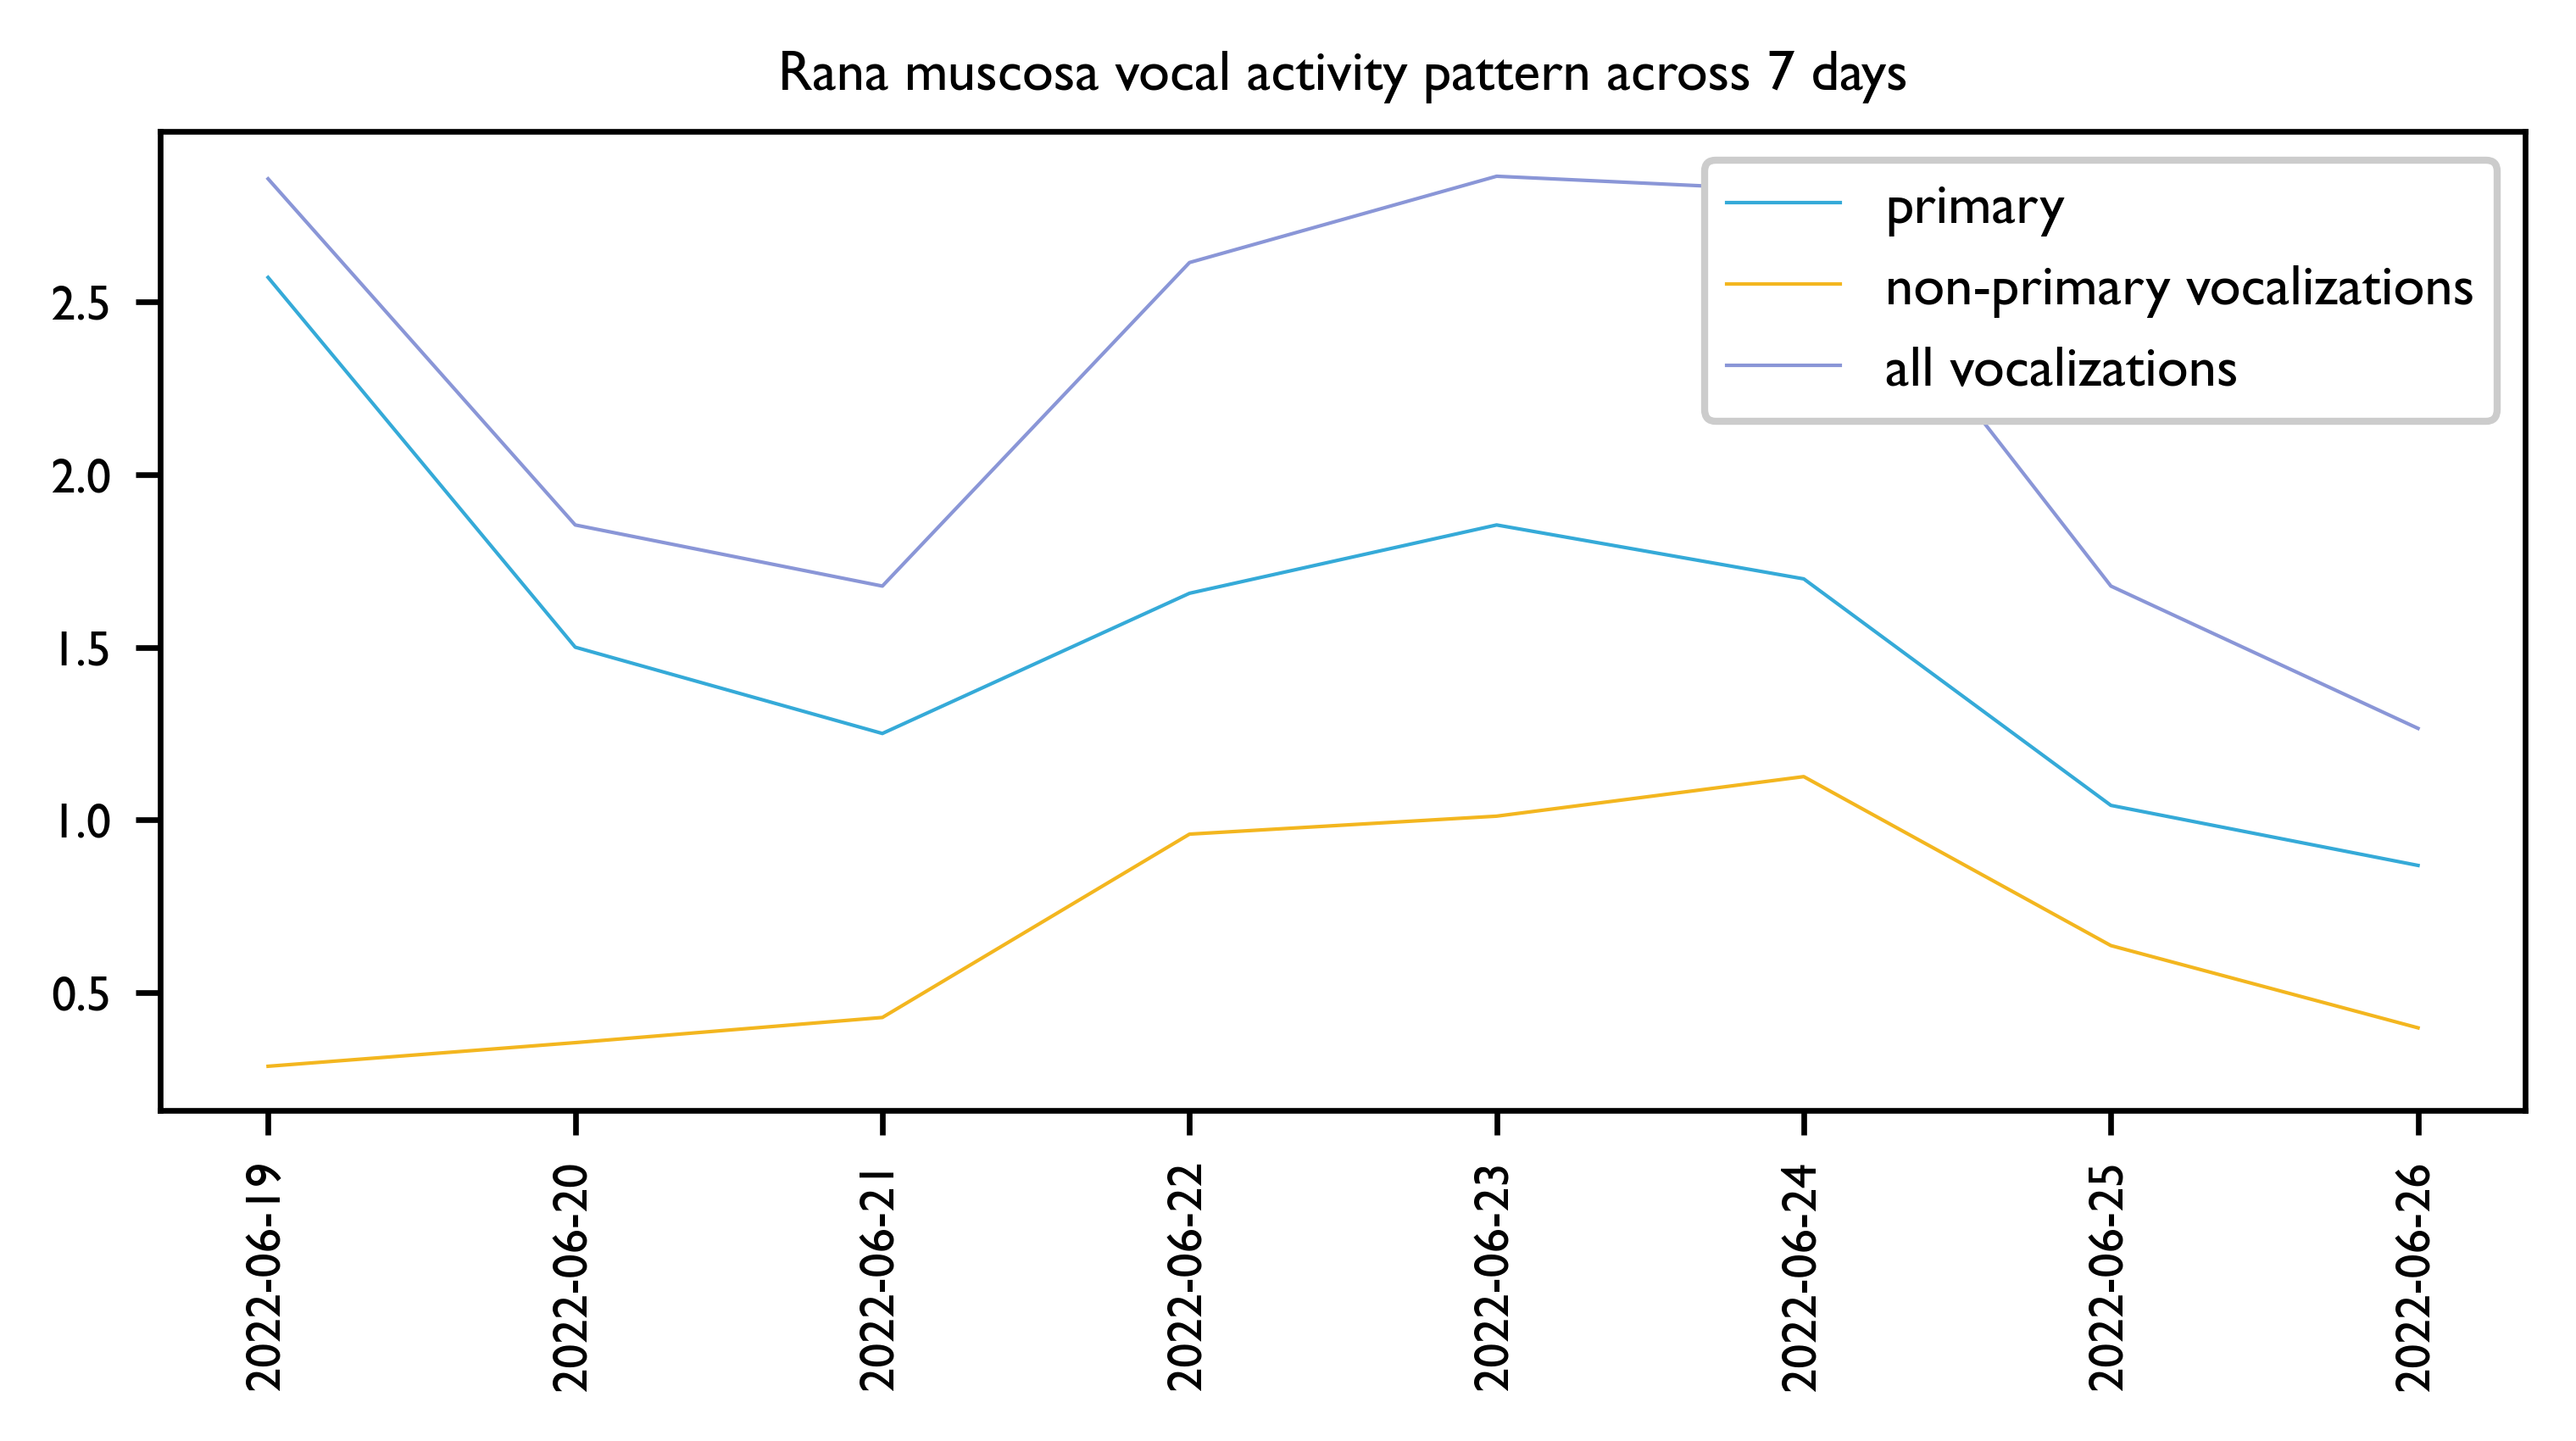

In [60]:
season = file_df.groupby('date').mean()
plt.plot(season.index,season.A+season.V,label='primary',linestyle='-')
plt.plot(season.index,season.sum(axis=1)-(season.A+season.V),label='non-primary vocalizations',linestyle='-')
plt.plot(season.index,season.sum(axis=1),label='all vocalizations',linestyle='-')

plt.xticks(rotation=90)
plt.legend()
plt.title("Rana muscosa vocal activity pattern across 7 days")
# plt.savefig('./figures/vocal_activity_annotated_7_days.pdf')
plt.show()

In [105]:
len(hourly)

666

In [106]:
len(file_df)

672

In [129]:
np.arange(0,len(file_df)-3,8)

array([  0,   8,  16,  24,  32,  40,  48,  56,  64,  72,  80,  88,  96,
       104, 112, 120, 128, 136, 144, 152, 160, 168, 176, 184, 192, 200,
       208, 216, 224, 232, 240, 248, 256, 264, 272, 280, 288, 296, 304,
       312, 320, 328, 336, 344, 352, 360, 368, 376, 384, 392, 400, 408,
       416, 424, 432, 440, 448, 456, 464, 472, 480, 488, 496, 504, 512,
       520, 528, 536, 544, 552, 560, 568, 576, 584, 592, 600, 608, 616,
       624, 632, 640, 648, 656, 664])

In [39]:
file_df = file_df.sort_index()

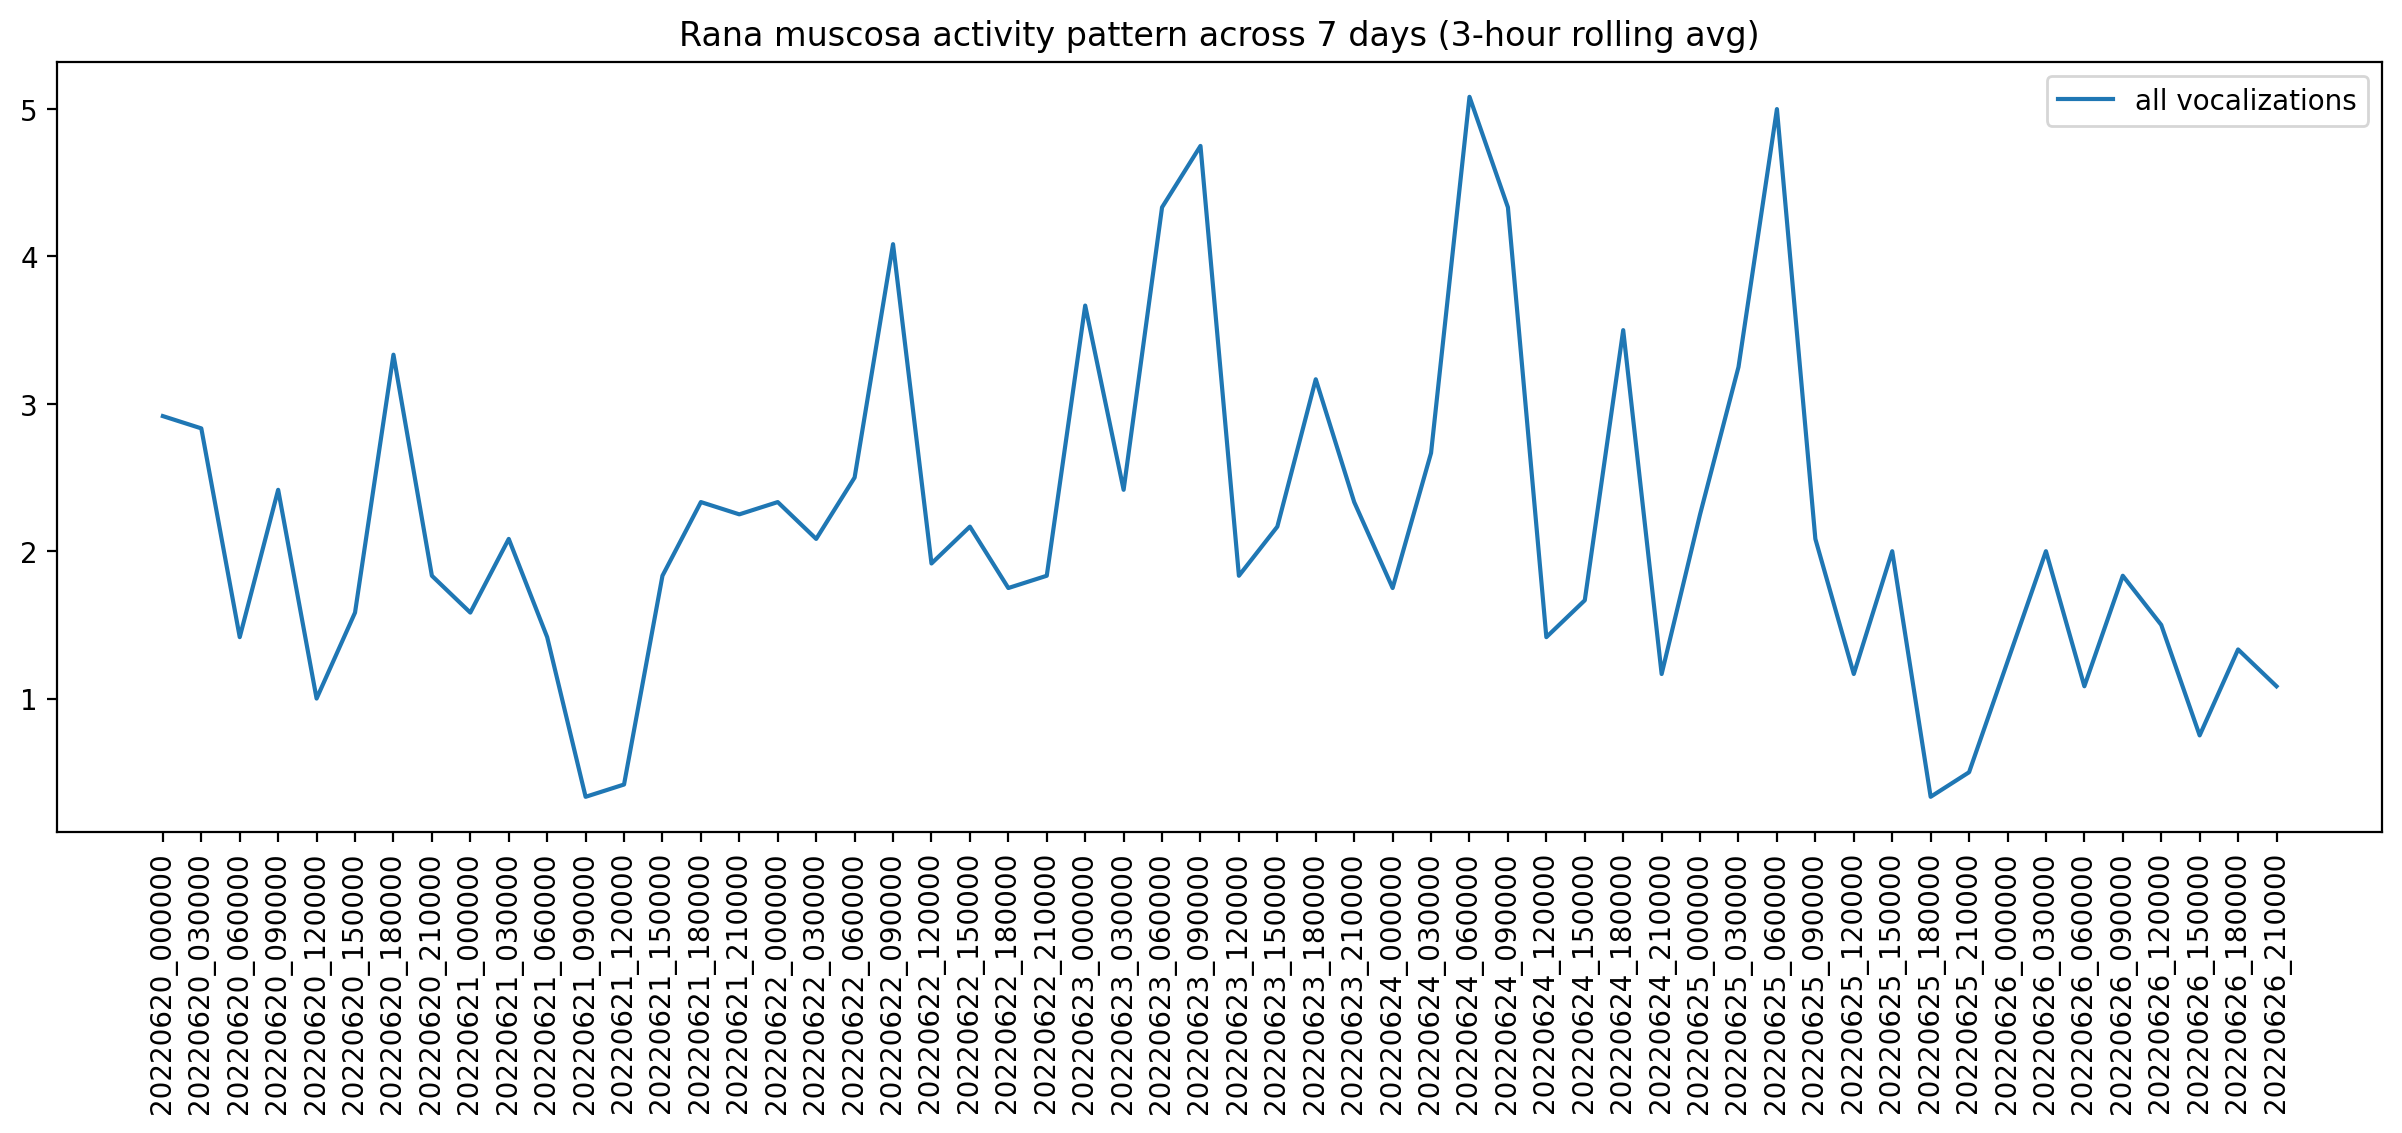

In [41]:
hourly = file_df.sum(axis=1).values
hourly = [np.mean(hourly[i:i+12]) for i in np.arange(0,len(file_df)-3,12)]
hours = [file_df.index[i][19:-6] for i in np.arange(0,len(file_df)-3,12)]

plt.plot(hours,hourly,label='all vocalizations')
plt.xticks(rotation=90)
plt.legend()
plt.title("Rana muscosa activity pattern across 7 days (3-hour rolling avg)")
plt.show()